# Load Modules

In [1]:
import pandas as pd
# import pandas_profiling
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('poster')
from sklearn.impute import SimpleImputer
import scipy
from scipy import stats
from scipy.stats import pearsonr
import statsmodels.api as sm
from statsmodels.formula.api import ols
from pandas.plotting import scatter_matrix
from pandas.plotting import autocorrelation_plot
from pandas.plotting import parallel_coordinates
from pandas.plotting import lag_plot

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score

# Load Data
## Load Relevant 2003 and 2004 LEAPS Datasets

In [2]:
# 2003 leaps data
child_03 = pd.read_stata('/Users/bentaylor/Documents/Data/LEAPS data/2003/public_child1.dta',
            columns = ['childcode', 'ch1_s1q3'])
child_roster_03 = pd.read_stata('/Users/bentaylor/Documents/Data/LEAPS data/2003/public_childroster1.dta',
            columns = ['childcode', 'cr1_s1q5', 'cr1_s2q6'])
hhs_household_03 = pd.read_stata('/Users/bentaylor/Documents/Data/LEAPS data/2003/public_hhsurvey1_household.dta',
            columns = ['hhid', 'mauzaid', 'hf1_s13q1_have', 'hf1_s13q3_have', 'hm1_s11q1'])
master_children_03 = pd.read_stata('/Users/bentaylor/Documents/Data/LEAPS data/2003/public_master_children1.dta',
            columns = ['childcode', 'hhid', 'child_teachercode1', 'child_schoolid1',
                      'child_english_scale1', 'child_urdu_scale1', 'child_math_scale1', 'child_female'])
teacher_roster_03 = pd.read_stata('/Users/bentaylor/Documents/Data/LEAPS data/2003/public_teacherroster1.dta',
            columns = ['child_teachercode1', 'tr1_s1q2', 'tr1_s1q4', 'tr1_s1q7', 'tr1_s1q8', 'tr1_s1q9',
                       'tr1_s1q10', 'tr1_s1q11'])
                
# 2004 leaps data
master_children_04 = pd.read_stata('/Users/bentaylor/Documents/Data/LEAPS data/2004/public_master_children2.dta',
            columns = ['childcode', 'hhid', 'child_teachercode2', 'child_female','child_english_scale2', 'child_math_scale2', 'child_urdu_scale2', 'child_class2'])
child_04 = pd.read_stata('/Users/bentaylor/Documents/Data/LEAPS data/2004/public_child2.dta',
            columns = ['childcode', 'ch2_s1q3', 'ch2_s2q2', 'ch2_s2q3']) # ch2_s0q1_code from correlation assessment
child_roster_04 = pd.read_stata('/Users/bentaylor/Documents/Data/LEAPS data/2004/public_childroster2.dta',
            columns = ['childcode', 'cr2_s2q6', 'cr2_s2q7'])
hhs_household_04 = pd.read_stata('/Users/bentaylor/Documents/Data/LEAPS data/2004/public_hhsurvey2_household.dta', convert_categoricals=False,
            columns = ['hhid', 'h2_s0q1_code', 'h2_s13q8', 'h2_s0q4_code'])
hhs_member_04 = pd.read_stata('/Users/bentaylor/Documents/Data/LEAPS data/2004/public_hhsurvey2_member.dta',
            columns = ['hhid', 'h2_s4q3_type', 'h2_s4q4',
                        'h2_s10q4_sub2', 'h2_s5q2e3'])
hhs_school_04 = pd.read_stata('/Users/bentaylor/Documents/Data/LEAPS data/2004/public_hhsurvey2_school.dta',
            columns = ['hhid'])
teacher_04 = pd.read_stata('/Users/bentaylor/Documents/Data/LEAPS data/2004/public_teacher2.dta',
            columns = ['teachercode2t','tq2_s3q1','tq2_s8q1','tq2_s8q3', 'tq2_s8q5'])
teacher_roster_04 = pd.read_stata('/Users/bentaylor/Documents/Data/LEAPS data/2004/public_teacherroster2.dta',
            columns = ['teachercode2tr', 'tr2_q4', 'tr2_q8', 'tr2_q7', 'tr2_q11'])

## Make DataFrame for 2003: df2003

In [3]:
grades_03 = master_children_03.rename(columns = {'child_english_scale1': 'english', 'child_urdu_scale1': 
                'urdu', 'child_math_scale1': 'math', 'child_female': 'student_sex'})

merge1_03 = pd.merge(grades_03, child_roster_03,
                on = 'childcode', how = 'left',suffixes=('left','right'))
merge1_03 = merge1_03.rename(columns = {'childcode': 'childcode', 'cr1_s1q5': 'grade',
                'cr1_s2q6': 'teacher_rates_child_how_good_in_studies'})

merge2_03 = pd.merge(merge1_03, child_03,
                on = 'childcode', how = 'left', suffixes = ('left','right'))
merge2_03 = merge2_03.rename(columns = {'childcode': 'childcode',
                'ch1_s1q3': 'child_studied_at_diff_school'})

merge3_03 = pd.merge(merge2_03, teacher_roster_03,
                on = 'child_teachercode1', how = 'left', suffixes = ('left','right'))
merge3_03 = merge3_03.rename(columns = {'child_teachercode1': 'child_teachercode', 'tr1_s1q2': 'teacher_sex',
                'tr1_s1q4': 'teacher_years_teaching',
                'tr1_s1q7': 'teacher_qualifications', 'tr1_s1q8': 'teacher_training', 'tr1_s1q9': 'salary_monthly_Rs',
                'tr1_s1q10': 'teacher_from_mauza',
                'tr1_s1q11': 'teacher_days_absent_last_mo'})

df2003 = pd.merge(merge3_03, hhs_household_03,
                on = 'hhid', how = 'left', suffixes = ('left','right'))
df2003 = df2003.rename(columns = {                                
                'hhid': 'hhid', 'hf1_s13q1_have': 'print_have',
                'hf1_s13q3_have': 'i_vis_have', # df2004.tv corresponds with this.
                'hm1_s10q1': 'death_5_years',
                'hm1_s11q1': 'own_agri_land_last_2_seasons'})

# add grade_median and grade_mean to df2003
df2003.insert(0, 'grade_median', df2003.iloc[:,3:6].median(numeric_only = True, axis = 1))

## Make DataFrame for 2004: df2004

In [4]:
grades_04 = master_children_04
grades_04 = grades_04.rename(columns = {'childcode': 'childcode', 'hhid': 'hhid',
                'child_teachercode2': 'child_teachercode',
                'child_female': 'student_sex', 'child_english_scale2': 'english',
                'child_math_scale2': 'math', 'child_urdu_scale2': 'urdu', 'child_class2': 'grade'})

# 04 hh_surveys
merge1_04 = pd.merge(grades_04, hhs_household_04, on = 'hhid', how = 'left')

merge2_04 = pd.merge(merge1_04, hhs_member_04, on = 'hhid', how = 'left')
merge2_04 = merge2_04.rename(columns = {'h2_s4q3_type': 'school_type',
                'h2_s4q4': 'studied_at_same_school_as_last_year'})

merge3_04 = pd.merge(merge2_04, hhs_school_04, on='hhid', how='left')

# 04 teachers
teacher_04 = teacher_04.rename(columns = {'teachercode2t': 'teachercode','tq2_s3q1': 'teacher_sex',
                'tq2_s8q1': 'teacher_survey_absent_emergency', 'tq2_s8q3':'teacher_survey_absent_office_work',
                'tq2_s8q5': 'teacher_survey_absent_other_work'})
merge3_04.insert(2, 'teachercode', teacher_04['teachercode']) # merge3_04 needs column 'teachercode' to merge on.
merge4_04 = pd.merge(merge3_04, teacher_04,
                on = 'teachercode', how = 'left') # this is a new kind of data, corresponding to teacher_days_absent_last_mo

teacher_roster_04 = teacher_roster_04.rename(columns = {'teachercode2tr': 'teachercode',
                'tr2_q4': 'teacher_years_teaching',
                'tr2_q7': 'teacher_qualifications', 'tr2_q8': 'teacher_training',
                'tr2_q11': 'teacher_from_mauza'})
merge5_04 = pd.merge(merge4_04, teacher_roster_04, on = 'teachercode', how = 'left')

# 04 students
merge6_04 = pd.merge(merge5_04, child_04, on = 'childcode', how = 'left')
merge6_04 = merge6_04.rename(columns = {'ch2_s1q3': 'child_studied_at_diff_school',
                'ch2_s2q2': 'radio', 'ch2_s2q3': 'television'}) # radio and TV replace audio and vis_i of 2003
                      
merge7_04 = pd.merge(merge6_04, child_roster_04, on = 'childcode', how = 'left')
df2004 = merge7_04.rename(columns = {'cr2_s2q6': 'child_days_absent_last_mo',
                # The online data does not specify 'month', but must be monthly because the range is 0-31.
                'cr2_s2q7': 'teacher_rates_child_how_good_in_studies', 'h2_s0q1_code': 'supervisor_code',
                'h2_s13q8': 'hh_child_in_govt_primary_school', 'h2_s0q4_code': 'tehsil_census_code',
                'h2_s10q4_sub2': 'child_helped', 'h2_s5q2e3': 'type_of_housework_timeslot_5'})

# add grade_median and grade_mean to df2004
df2004.insert(0, 'grade_median', df2004.iloc[:, 4:7].median(numeric_only = True, axis = 1))

# Clean Data

## Missing Data and Solutions

In [5]:
# The below percentage shows there is much missing data for 2003 outside
# of the targeted questionnaires. Missing target variables have already been dealt with in the df grades.
total = df2003.isnull().sum().sort_values(ascending=False)
percent = (df2003.isnull().sum()/df2003.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Missing Percent'])
missing_data['Missing Percent'] = missing_data['Missing Percent'].apply(lambda x: x * 100)
print(missing_data[missing_data['Total'] > 0].round({'Missing Percent': 2}))

                                         Total  Missing Percent
own_agri_land_last_2_seasons             12741            92.76
i_vis_have                               12738            92.74
print_have                               12738            92.74
mauzaid                                  12738            92.74
hhid                                     12738            92.74
child_studied_at_diff_school              7363            53.61
teacher_rates_child_how_good_in_studies   7347            53.49
math                                      1625            11.83
urdu                                      1625            11.83
english                                   1625            11.83
teacher_training                           280             2.04
teacher_days_absent_last_mo                117             0.85
teacher_from_mauza                          56             0.41
salary_monthly_Rs                           19             0.14
teacher_years_teaching                  

In [6]:
# The below percentage shows there is much missing data for 2004 outside
# of the targeted questionnaires. All missing target variables have already been dealt with in the df grades.
total = df2004.isnull().sum().sort_values(ascending=False)
percent = (df2004.isnull().sum() / df2004.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Missing Percent'])
missing_data['Missing Percent'] = missing_data['Missing Percent'].apply(lambda x: x * 100)
print(missing_data[missing_data['Total'] > 0].round({'Missing Percent': 2}))

                                          Total  Missing Percent
teacher_years_teaching                   108363            99.27
teacher_from_mauza                       108362            99.27
teacher_qualifications                   108361            99.27
teacher_training                         108361            99.27
teacher_survey_absent_other_work         108361            99.27
teacher_survey_absent_office_work        108361            99.27
teacher_survey_absent_emergency          108361            99.27
teacher_sex                              108361            99.27
teachercode                              108361            99.27
type_of_housework_timeslot_5             107934            98.88
child_helped                             107417            98.41
studied_at_same_school_as_last_year       81069            74.27
school_type                               81069            74.27
television                                64725            59.29
radio                    

## Analysis of and Solutions for df2003 and df2004
### df2003 Analysis
The English, Urdu, and Math columns have several NaNs, and the median of the three are the target variable. They must all be dropped.<br>
Household (12,738) and teacher (~7,350) questionnaires can be left as NaN, as that's how the data gatherers intended the missing amount to look (unless I want to fill the missing events for those who filled out the questionnaires).<br><br>

### df2004 Analysis
As with df2003, The English, Urdu, and Math columns have several NaNs, and the median of the three are the target variable. They must all be dropped.<br>
The Household (~8,100) and teacher (10,8361) questionnaires can be left as NaN, as that's how the data gatherers intended the missing amount to look (unless I want to fill the missing events for those who filled out the questionnaires).<br><br>

### Solutions
(The true target variable is the median of english, urdu, and math, and the three grades it is based on I here call the target variables in order to avoid encumbersome language.)<br>
I will drop all the rows with NaN instances in the grade_median columns of each DataFrame because they constitute the target variable for predictive modeling.
<br><br>
I will fill the missing data that is less than 3% with the most common value, except for the "sex" column in df2004, which I will fill with the less common value "Male" (viz. 1).
<br><br>
(I have already dropped the missing data for my target variables in the grades DataFrame.)

# QUESTIONS

What do I do with majorly missing data? It's not a problem conceptually but is when I think of how to put it in code.<br>
Should I convert grade to integers? (3rd or 4th grade)

### Drop all NaN values from the target variable per year

In [7]:
df2003 = df2003[df2003['grade_median'].notna()]
df2003 = df2003[df2003['english'].notna()]
df2003 = df2003[df2003['urdu'].notna()]
df2003 = df2003[df2003['math'].notna()]

df2004 = df2004[df2004['grade_median'].notna()]
df2004 = df2004[df2004['english'].notna()]
df2004 = df2004[df2004['urdu'].notna()]
df2004 = df2004[df2004['math'].notna()]

### df2003: Fill in the missing values of the missing data that is less than 3%. I use sklearn.impute.SimpleImputer¶

In [8]:
imr = SimpleImputer(strategy='most_frequent')
imr = imr.fit(df2003[['teacher_training']])
df2003.teacher_training = imr.transform(df2003[['teacher_training']]).ravel()

In [9]:
imr = SimpleImputer(strategy='most_frequent')
imr = imr.fit(df2003[['teacher_days_absent_last_mo']])
df2003.teacher_days_absent_last_mo = imr.transform(df2003[['teacher_days_absent_last_mo']]).ravel()

In [10]:
imr = SimpleImputer(strategy='most_frequent')
imr = imr.fit(df2003[['teacher_days_absent_last_mo']])
df2003.teacher_days_absent_last_mo = imr.transform(df2003[['teacher_days_absent_last_mo']]).ravel()
# I change the floats to integers because no one missed a fraction of a day in this survey,
# indicating such was not an option for participants.
df2003.teacher_days_absent_last_mo = df2003.teacher_days_absent_last_mo.astype(int)

In [11]:
imr = SimpleImputer(strategy='most_frequent')
imr = imr.fit(df2003[['teacher_from_mauza']])
df2003.teacher_from_mauza = imr.transform(df2003[['teacher_from_mauza']]).ravel()

In [12]:
imr = SimpleImputer(strategy='most_frequent')
imr = imr.fit(df2003[['teacher_years_teaching']])
df2003.teacher_years_teaching = imr.transform(df2003[['teacher_years_teaching']]).ravel()

In [13]:
imr = SimpleImputer(strategy='most_frequent')
imr = imr.fit(df2003[['salary_monthly_Rs']])
df2003.salary_monthly_Rs = imr.transform(df2003[['salary_monthly_Rs']]).ravel()

### df2004: Fill in the missing values of the missing data that is less than 3%.

In [14]:
imr = SimpleImputer(strategy='most_frequent')
imr = imr.fit(df2004[['child_teachercode']])
df2004.child_teachercode = imr.transform(df2004[['child_teachercode']]).ravel()

In [15]:
imr = SimpleImputer(strategy='most_frequent')
imr = imr.fit(df2004[['grade']])
df2004.grade = imr.transform(df2004[['grade']]).ravel()

#### If I had more computing power, I would fill the missing ~3% of data using MICE (see code below) instead of the average in each category.<br>
cf. https://towardsdatascience.com/stop-using-mean-to-fill-missing-data-678c0d396e22
<br><br>

from impyute.imputation.cs import mice <br>

X = grades.drop('childcode', axis=1).values <br>

imputed = mice(X) <br>
mice_ages = imputed[:, 2]

grades.describe()

# Back to Data Cleaning

## Convert strings to integers

### I performed this after the Cleaning Data section to make more intuitive graphs.

In [16]:
# Dictionaries
# 5 is the number for NaNs
sex_int = {'Female': 0, 'Male': 1, np.nan: 5}
yes_no_int = {'No': 0, 'no': 0, 'Yes': 1, 'yes': 1, np.nan: 5}
school_type_int = {'Public': 0, 'Private': 1, 'Madrassa': 2, np.nan: 5}

# df2003
df2003.student_sex = [sex_int[item] for item in df2003.student_sex] 
df2003.teacher_sex = [sex_int[item] for item in df2003.teacher_sex]
df2003.child_studied_at_diff_school = [yes_no_int[item] for item in df2003.child_studied_at_diff_school]
df2003.own_agri_land_last_2_seasons = [yes_no_int[item] for item in df2003.own_agri_land_last_2_seasons]
df2003.i_vis_have = [yes_no_int[item] for item in df2003.i_vis_have]
df2003.print_have = [yes_no_int[item] for item in df2003.print_have]
df2003.teacher_from_mauza = [yes_no_int[item] for item in df2003.teacher_from_mauza]

In [17]:
# df2004.student_sex = [sex_int[item] for item in df2004.student_sex]
df2004.teacher_sex = [sex_int[item] for item in df2004.teacher_sex]
df2004.school_type = [school_type_int[item] for item in df2004.school_type]
df2004.studied_at_same_school_as_last_year = [yes_no_int[item] for item in df2004.studied_at_same_school_as_last_year]
df2004.teacher_survey_absent_emergency = [yes_no_int[item] for item in df2004.teacher_survey_absent_emergency]
df2004.teacher_survey_absent_office_work = [yes_no_int[item] for item in df2004.teacher_survey_absent_office_work]
df2004.teacher_survey_absent_other_work = [yes_no_int[item] for item in df2004.teacher_survey_absent_other_work]
df2004.teacher_from_mauza = [yes_no_int[item] for item in df2004.teacher_from_mauza]
df2004.child_studied_at_diff_school = [yes_no_int[item] for item in df2004.child_studied_at_diff_school]
df2004.radio = [yes_no_int[item] for item in df2004.radio]
df2004.television = [yes_no_int[item] for item in df2004.television]

In [18]:
# Here, I fill NaN values with the lesser observed sex: males.
imr = SimpleImputer(strategy='constant', fill_value=1)
imr = imr.fit(df2004[['student_sex']])
df2004.student_sex = imr.transform(df2004[['student_sex']]).ravel()

## Make Numeric-Only DataFrames for Predictive Modeling

In [19]:
df2003_num = df2003.copy()
df2003_num = df2003_num.drop(columns = ['hhid',
                    'mauzaid', 'teacher_rates_child_how_good_in_studies',
                    'teacher_years_teaching', 'teacher_qualifications', 'teacher_training',
                    'child_studied_at_diff_school', 'print_have', 'i_vis_have'])
print('Numeric-Only DataFrame for 2003:\n')
df2003_num.info()
print('\n\nNo NaNs or "None" objects:\n')
df2003_num.isna().sum()

Numeric-Only DataFrame for 2003:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12110 entries, 0 to 13734
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   grade_median                  12110 non-null  float64
 1   childcode                     12110 non-null  object 
 2   child_teachercode             12110 non-null  int32  
 3   child_schoolid1               12110 non-null  int8   
 4   english                       12110 non-null  float64
 5   urdu                          12110 non-null  float64
 6   math                          12110 non-null  float64
 7   student_sex                   12110 non-null  int64  
 8   grade                         12110 non-null  int8   
 9   teacher_sex                   12110 non-null  int64  
 10  salary_monthly_Rs             12110 non-null  float64
 11  teacher_from_mauza            12110 non-null  int64  
 12  teacher_days_absent_last_m

grade_median                    0
childcode                       0
child_teachercode               0
child_schoolid1                 0
english                         0
urdu                            0
math                            0
student_sex                     0
grade                           0
teacher_sex                     0
salary_monthly_Rs               0
teacher_from_mauza              0
teacher_days_absent_last_mo     0
own_agri_land_last_2_seasons    0
dtype: int64

In [20]:
df2004_num = df2004.copy()
df2004_num = df2004_num.drop(columns = ['teacher_years_teaching', 'teachercode', 'teacher_qualifications',
                    'teacher_training', 'type_of_housework_timeslot_5', 'child_helped',
                    'teacher_rates_child_how_good_in_studies',
                    'child_days_absent_last_mo', 'hh_child_in_govt_primary_school',
                    'supervisor_code', 'tehsil_census_code',
                    'hhid'])
print('Numeric-Only DataFrame for 2004:\n')
df2004_num.info()
print('\n\nNo NaNs or "None" objects:\n')
df2004_num.isna().sum()

Numeric-Only DataFrame for 2004:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64218 entries, 0 to 109147
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   grade_median                         64218 non-null  float64
 1   childcode                            64218 non-null  int32  
 2   child_teachercode                    64218 non-null  float64
 3   student_sex                          64218 non-null  float64
 4   english                              64218 non-null  float64
 5   math                                 64218 non-null  float64
 6   urdu                                 64218 non-null  float64
 7   grade                                64218 non-null  float64
 8   school_type                          64218 non-null  int64  
 9   studied_at_same_school_as_last_year  64218 non-null  int64  
 10  teacher_sex                          64218 non-null  int64 

grade_median                           0
childcode                              0
child_teachercode                      0
student_sex                            0
english                                0
math                                   0
urdu                                   0
grade                                  0
school_type                            0
studied_at_same_school_as_last_year    0
teacher_sex                            0
teacher_survey_absent_emergency        0
teacher_survey_absent_office_work      0
teacher_survey_absent_other_work       0
teacher_from_mauza                     0
child_studied_at_diff_school           0
radio                                  0
television                             0
dtype: int64

# Outliers

## I cram the data into a normal bell curve using boxcox and then add the fitted data into the grades DataFrame. 

### Boxcox and df2003.grade_median

#### Boxcox will not compute numbers less than or equal to 0, so I replace 0s with the next closest number: 1.

In [26]:
df2004.grade_median.replace(to_replace=0, value=1, inplace=True)
df2004.grade_median.where(df2004.grade_median < 0.001).count()

0

In [27]:
fitted_data_03, fitted_lambda_03 = stats.boxcox(df2003.grade_median)

### Boxcox and df2004.grade_median

#### Boxcox will not compute numbers less than or equal to 0, so I replace 0s with the next closest number: 1.

In [32]:
df2004.grade_median.replace(to_replace=0, value=1, inplace=True)
df2004.grade_median.where(df2004.grade_median < 0.001).count()

0

In [33]:
fitted_data_04, fitted_lambda_04 = stats.boxcox(df2004.grade_median)

### Add the fitted data in the DataFrames

In [38]:
# Add two columns of the fitted data from boxcox
df2003.insert(1, 'grade_median_fitted', fitted_data_03)
df2003_num.insert(1, 'grade_median_fitted', fitted_data_03)
df2004.insert(1, 'grade_median_fitted', fitted_data_04)
df2004_num.insert(1, 'grade_median_fitted', fitted_data_04)

### Compare and Contrast

# Prepare for Predictive Modeling

## Create and Reshape Variables

In [40]:
# Create arrays for features and target variable
y2003 = df2003_num['grade_median_fitted'].copy().values
X2003 = df2003_num.copy().drop(['grade_median', 'grade_median_fitted'], axis=1)
X2003_no_derivatives = df2003_num.copy().drop(['grade_median', 'grade_median_fitted',
                                'math', 'english', 'urdu'], axis=1)
X2003_columns = X2003.copy().columns

y2004 = df2004_num['grade_median_fitted'].copy().values
X2004 = df2004_num.copy().drop('grade_median_fitted', axis=1)
X2004_no_derivatives = df2004_num.copy().drop(['grade_median', 'grade_median_fitted',
                                'math', 'english', 'urdu'], axis=1)
X2004_columns = X2004.copy().columns

In [41]:
print(type(y2003))
print(type(X2003))
print(type(X2003_columns))

<class 'numpy.ndarray'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.indexes.base.Index'>


# Predictive Modeling

## 1. Linear Regression

### 2003

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X2003, y2003, test_size=.3,random_state=42)

reg = LinearRegression()

reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)

print('R^2: {}'.format(reg.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  

print('Root Mean Squared Error: {}'.format(rmse))
print('Mean of RMSE: {}'.format(np.mean(cross_val_score(reg,X2003,y2003,
                                scoring='neg_mean_squared_error', cv=5))))
print('Linear Regression Score:', reg.score(X_test, y_test))

R^2: 0.9383675011236617
Mean Absolute Error: 271.557350947338
Root Mean Squared Error: 353.2639276250026
Mean of RMSE: -130544.09117819217
Linear Regression Score: 0.9383675011236617


In [43]:
coeff_03 = pd.DataFrame(reg.coef_, X2003.columns, columns=['Coefficient'])
coeff_03.sort_values(by='Coefficient', ascending=False)

,Coefficient
grade,44.781093
teacher_sex,10.133302
own_agri_land_last_2_seasons,5.320516
english,5.116143
urdu,5.104502
teacher_from_mauza,0.975854
childcode,0.083700
salary_monthly_Rs,-0.005418
child_schoolid1,-0.203828
math,-0.216974


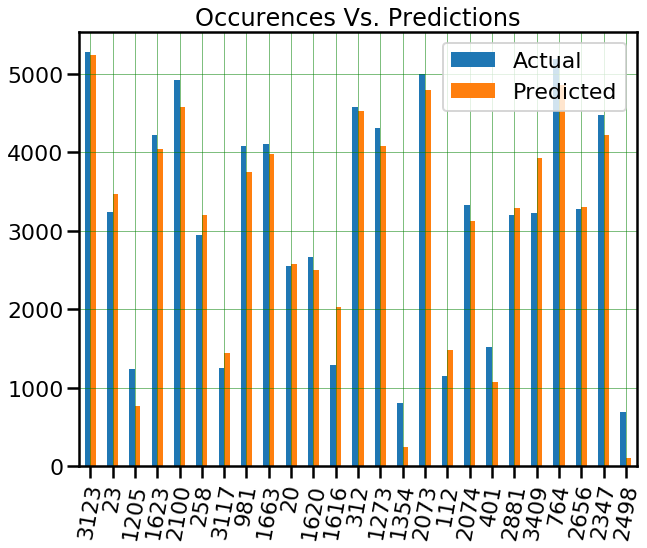

In [44]:
df_y_pred = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df_y_pred1 = df_y_pred.sample(25)

_ = df_y_pred1.plot(kind='bar',figsize=(10,8))
_ = plt.title('Occurences Vs. Predictions')
_ = plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
_ = plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
_ = plt.xticks(rotation=80)
_ = plt.show()

In [46]:
reg = LinearRegression()
cv_scores = cross_val_score(reg, X2003, y2003, cv=5)
print('CV Scores:', cv_scores)

print('Average 5-Fold CV Score: {}'.format(np.mean(cv_scores)))

CV Scores: [0.94646724 0.94383624 0.92294905 0.93246112 0.93319571]
Average 5-Fold CV Score: 0.9357818710373106


In [47]:
reg = LinearRegression()

# 3-Fold Cross Validation
cvscores_3 = cross_val_score(reg, X2003, y2003, cv=3)
print('Mean of 3 CV:', np.mean(cvscores_3))

# 10 Fold
cvscores_10 = cross_val_score(reg, X2003, y2003, cv=10)
print('Mean of 10 CV:', np.mean(cvscores_10))

# Print the accuracy from the testing data
# accuracy_score(reg.fit(y_03, y_pred))
# print(accuracy_score(reg.predict(y_03), y_pred))

Mean of 3 CV: 0.9333430089760495
Mean of 10 CV: 0.9348798210724638


### 2003 No Derivatives

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X2003_no_derivatives, y2003, test_size=.3,random_state=42)

reg = LinearRegression()

reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)

print('R^2: {}'.format(reg.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  

print('Root Mean Squared Error: {}'.format(rmse))
print('Mean of RMSE: {}'.format(np.mean(cross_val_score(reg,X2003,y2003,
                                scoring='neg_mean_squared_error', cv=5))))
print('Linear Regression Score:', reg.score(X_test, y_test))

R^2: 0.1399609779559613
Mean Absolute Error: 1085.1528800577453
Root Mean Squared Error: 1319.6339598052334
Mean of RMSE: -130544.09117819217
Linear Regression Score: 0.1399609779559613


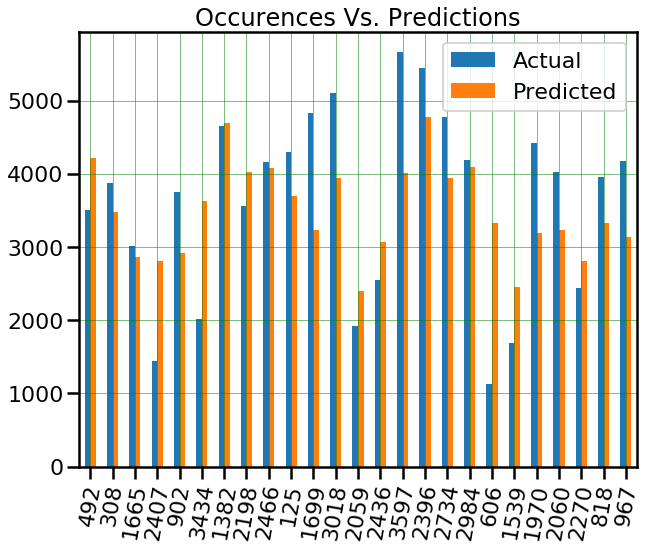

In [49]:
df_y_pred = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df_y_pred1 = df_y_pred.sample(25)

_ = df_y_pred1.plot(kind='bar',figsize=(10,8))
_ = plt.title('Occurences Vs. Predictions')
_ = plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
_ = plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
_ = plt.xticks(rotation=80)
_ = plt.show()

In [50]:
reg = LinearRegression()
cv_scores = cross_val_score(reg, X2003_no_derivatives, y2003, cv=5)
print('CV Scores:', cv_scores)

print('Average 5-Fold CV Score: {}'.format(np.mean(cv_scores)))

CV Scores: [0.17353568 0.15737363 0.09157907 0.10719272 0.03964194]
Average 5-Fold CV Score: 0.11386460972072862


In [51]:
reg = LinearRegression()

# 3-Fold Cross Validation
cvscores_3 = cross_val_score(reg, X2003_no_derivatives, y2003, cv=3)
print('Mean of 3 CV:', np.mean(cvscores_3))

# 10 Fold
cvscores_10 = cross_val_score(reg, X2003_no_derivatives, y2003, cv=10)
print('Mean of 10 CV:', np.mean(cvscores_10))

# Print the accuracy from the testing data
# accuracy_score(reg.fit(y_03, y_pred))
# print(accuracy_score(reg.predict(y_03), y_pred))

Mean of 3 CV: 0.09978340127190277
Mean of 10 CV: 0.10988943517117344


### 2004

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X2004, y2004, test_size=.3,random_state=42)

reg = LinearRegression()

reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)

print('R^2: {}'.format(reg.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  

print('Root Mean Squared Error: {}'.format(rmse))
print('Mean of RMSE: {}'.format(np.mean(cross_val_score(reg,X2003,y2003,
                                scoring='neg_mean_squared_error', cv=5))))
print('Linear Regression Score:', reg.score(X_test, y_test))

R^2: 0.9861712030826679
Mean Absolute Error: 129.13483150650163
Root Mean Squared Error: 194.43313951468488
Mean of RMSE: -130544.09117819217
Linear Regression Score: 0.9861712030826679


In [53]:
coeff_04 = pd.DataFrame(reg.coef_, X2004.columns, columns=['Coefficient'])
coeff_04.sort_values(by='Coefficient', ascending=False)

,Coefficient
school_type,29.856726
television,16.455637
teacher_survey_absent_office_work,15.853594
teacher_survey_absent_other_work,11.259020
grade_median,9.251267
teacher_sex,2.277348
english,0.822612
math,0.454645
urdu,0.360114
childcode,0.000009


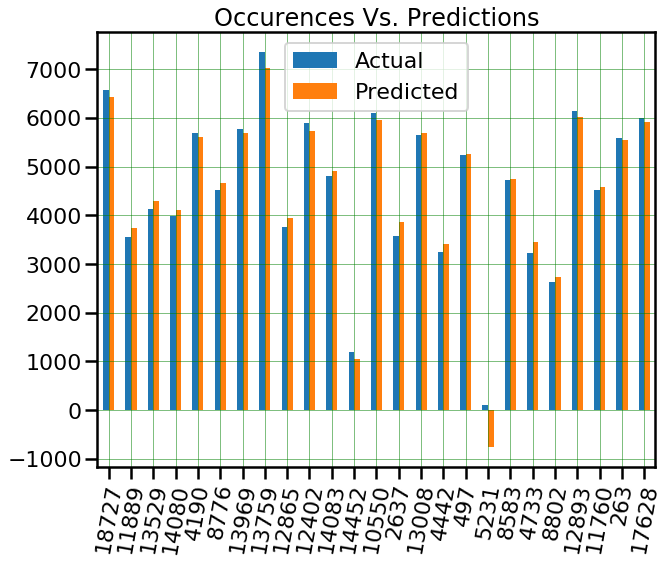

In [54]:
df_y_pred = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df_y_pred1 = df_y_pred.sample(25)

_ = df_y_pred1.plot(kind='bar',figsize=(10,8))
_ = plt.title('Occurences Vs. Predictions')
_ = plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
_ = plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
_ = plt.xticks(rotation=80)
_ = plt.show()

In [55]:
reg = LinearRegression()
cv_scores = cross_val_score(reg, X2003, y2003, cv=5)
print('CV Scores:', cv_scores)

print('Average 5-Fold CV Score: {}'.format(np.mean(cv_scores)))

CV Scores: [0.94646724 0.94383624 0.92294905 0.93246112 0.93319571]
Average 5-Fold CV Score: 0.9357818710373106


In [56]:
reg = LinearRegression()

# 3-Fold Cross Validation
cvscores_3 = cross_val_score(reg, X2003, y2003, cv=3)
print('Mean of 3 CV:', np.mean(cvscores_3))

# 10 Fold
cvscores_10 = cross_val_score(reg, X2003, y2003, cv=10)
print('Mean of 10 CV:', np.mean(cvscores_10))

# Print the accuracy from the testing data
# accuracy_score(reg.fit(y2003, y_pred))
# print(accuracy_score(reg.predict(y_03), y_pred))

Mean of 3 CV: 0.9333430089760495
Mean of 10 CV: 0.9348798210724638


### 2004 No Derivatives

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X2004_no_derivatives, y2004, test_size=.3,random_state=42)

reg = LinearRegression()

reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)

print('R^2: {}'.format(reg.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  

print('Root Mean Squared Error: {}'.format(rmse))
print('Mean of RMSE: {}'.format(np.mean(cross_val_score(reg, X2004_no_derivatives, y2004,
                                scoring='neg_mean_squared_error', cv=5))))
print('Linear Regression Score:', reg.score(X_test, y_test))

R^2: 0.0977037070040393
Mean Absolute Error: 1225.2304232322517
Root Mean Squared Error: 1570.553286434264
Mean of RMSE: -2667895.355364886
Linear Regression Score: 0.0977037070040393


In [58]:
coeff_04 = pd.DataFrame(reg.coef_, X2004_no_derivatives.columns, columns=['Coefficient'])
coeff_04.sort_values(by='Coefficient', ascending=False)

,Coefficient
grade,864.174910
school_type,546.820686
child_studied_at_diff_school,103.798936
student_sex,81.863019
teacher_survey_absent_emergency,55.376457
teacher_survey_absent_office_work,43.162545
television,22.974085
childcode,0.000377
child_teachercode,-0.002949
teacher_sex,-36.104980


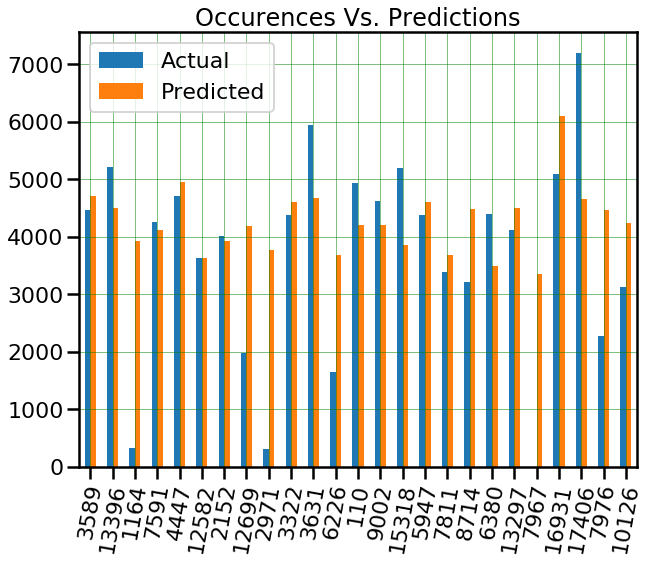

In [59]:
df_y_pred = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df_y_pred1 = df_y_pred.sample(25)

_ = df_y_pred1.plot(kind='bar',figsize=(10,8))
_ = plt.title('Occurences Vs. Predictions')
_ = plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
_ = plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
_ = plt.xticks(rotation=80)
_ = plt.show()

In [60]:
reg = LinearRegression()
cv_scores = cross_val_score(reg, X2004_no_derivatives, y2004, cv=5)
print('CV Scores:', cv_scores)

print('Average 5-Fold CV Score: {}'.format(np.mean(cv_scores)))

CV Scores: [ 0.00512663  0.00458366  0.00776507 -0.10022203 -0.17447813]
Average 5-Fold CV Score: -0.05144496173297104


In [61]:
reg = LinearRegression()

# 3-Fold Cross Validation
cvscores_3 = cross_val_score(reg, X2004_no_derivatives, y2004, cv=3)
print('Mean of 3 CV:', np.mean(cvscores_3))

# 10 Fold
cvscores_10 = cross_val_score(reg, X2004_no_derivatives, y2004, cv=10)
print('Mean of 10 CV:', np.mean(cvscores_10))

# Print the accuracy from the testing data
# accuracy_score(reg.fit(y2003, y_pred))
# print(accuracy_score(reg.predict(y_03), y_pred))

Mean of 3 CV: 0.004874737324731686
Mean of 10 CV: -0.026453778649572813


### The "No Derivatives" dataset perform quite poorly (about 0.1). This makes some sense in that research psychologists have not found factors with stronger predictive power in terms of completing complex tasks than those that assess intelligence, namely, IQ and the g factor.